In [1]:
import pandas as pd
import warnings


warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('dataset.xlsx')
df.head()

,Sentence,Outcome
0,What is the difference between depression and ...,C
1,What are other psychiatric conditions that can...,C
2,Why is depression more prevalent in women than...,C
3,What happens during menopause with regards to ...,C
4,What efforts are underway to improve treatment...,C


In [3]:
col = ['Sentence', 'Outcome']
df = df[col]
df.columns = ['Sentence', 'Outcome']
df['category_id'] = df['Outcome'].factorize()[0]
category_id_df = df[['Outcome', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Outcome']].values)
df.head()

,Sentence,Outcome,category_id
0,What is the difference between depression and ...,C,0
1,What are other psychiatric conditions that can...,C,0
2,Why is depression more prevalent in women than...,C,0
3,What happens during menopause with regards to ...,C,0
4,What efforts are underway to improve treatment...,C,0


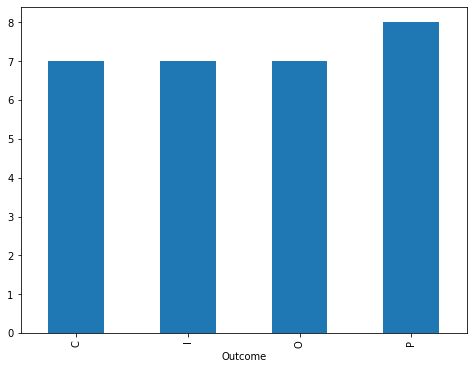

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Outcome').Sentence.count().plot.bar(ylim=0)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', stop_words='english')
features = tfidf.fit_transform(df.Sentence).toarray()
labels = df.category_id
features.shape

In [ ]:
for i in features:
    print(i,len(i))

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X=df['Sentence']
y=df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(df['Sentence'], df['Outcome'], random_state = 0)
X_train=X
y_train=y
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
print(clf.predict(count_vect.transform(["Depression in men or women"])))

In [ ]:
print(clf.predict(count_vect.transform(["Depression"])))

In [ ]:
print(clf.predict(count_vect.transform(["Depression affect me"])))

In [ ]:
print(clf.predict(count_vect.transform(["Depression treated"])))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(max_depth=10, min_samples_leaf=7, n_estimators=7,n_jobs=-1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=20, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=3)
X_train, y_train
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Outcome.values, yticklabels=category_id_df.Outcome.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Outcome', 'Sentence']])
            print('')